In [1]:
#import thinkplot
#import thinkstats2
import pandas as pd
import numpy as np
import math
import scipy.stats as ss
import thinkplot
import thinkstats2
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,5)

# Quiz 2 - Get Hyp'

<ul>
<li> Use this as a starting point for your work, but answer the questions on Moodle. 
<li> Publish this to your GitHub and submit the link in the question on Moodle. 
</ul>

## Potentially Useful Information

#### Data Dictionary
<ul>
<li>credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
<li>purpose: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other").
<li>int.rate: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.
<li>installment: The monthly installments owed by the borrower if the loan is funded.
<li>log.annual.inc: The natural log of the self-reported annual income of the borrower.
<li>dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income).
<li>fico: The FICO credit score of the borrower.
<li>days.with.cr.line: The number of days the borrower has had a credit line.
<li>revol.bal: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).
<li>revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).
<li>inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months.
<li>not.fully.paid: 1 if the borrower failed to repay their loan, 0 if they have not failed
</ul>

#### FICO Score Groups

![FICO](fico_range.png "FICO Ranges")

#### Note on ANOVA - Might be Useful, Might Not

> @JeremyMiles is right. First, there's a rule of thumb that the ANOVA is robust to heterogeneity of variance so long as the largest variance is not more than 4 times the smallest variance. Furthermore, the general effect of heterogeneity of variance is to make the ANOVA less efficient. That is, you would have lower power. Since you have a significant effect anyway, there is less reason to be concerned here. 
- https://stats.stackexchange.com/questions/56971/alternative-to-one-way-anova-unequal-variance

In [2]:
# Please don't alter this part. 
df = pd.read_csv("loan_data.csv")
df.drop(columns={"delinq.2yrs", "pub.rec"}, inplace=True)
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,0


### Visualize/Explore Data - If You Want, You Do You

In [14]:
#not fully paid with 1
df3 = df[df["not.fully.paid"] == 1]
df3.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,not.fully.paid
count,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1.533000e+03,1533.000000,1533.000000,1533.0
mean,0.661448,0.132452,342.785114,10.885023,13.195838,697.828441,4393.541259,2.106629e+04,52.255075,2.330724,1.0
std,0.473372,0.025495,223.948527,0.666718,7.006769,33.756808,2431.785491,4.990569e+04,29.057906,2.933480,0.0
min,0.000000,0.070500,15.910000,7.600902,0.000000,617.000000,180.041667,0.000000e+00,0.000000,0.000000,1.0
25%,0.000000,0.115400,168.640000,10.491274,7.830000,672.000000,2759.958333,3.323000e+03,29.900000,0.000000,1.0
50%,1.000000,0.131600,287.310000,10.878047,13.340000,692.000000,4050.000000,8.850000e+03,53.900000,1.000000,1.0
75%,1.000000,0.148200,491.300000,11.276633,18.830000,717.000000,5580.041667,2.061600e+04,77.000000,3.000000,1.0
max,1.000000,0.216400,926.830000,13.458836,29.960000,822.000000,15692.000000,1.207359e+06,106.500000,33.000000,1.0


In [15]:
df4 = df[df["not.fully.paid"] == 0]
df4.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,not.fully.paid
count,8045.000000,8045.000000,8045.000000,8045.000000,8045.000000,8045.000000,8045.000000,8045.000000,8045.000000,8045.000000,8045.0
mean,0.832318,0.120770,314.574123,10.941091,12.494413,713.326911,4592.632624,16122.724425,45.759608,1.433934,0.0
std,0.373607,0.026692,203.398688,0.604045,6.855020,38.223723,2508.035500,29637.645740,28.891285,1.999009,0.0
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000,0.000000,0.000000,0.0
25%,1.000000,0.099600,162.250000,10.584056,7.120000,682.000000,2820.041667,3171.000000,21.400000,0.000000,0.0
50%,1.000000,0.121800,266.520000,10.933178,12.530000,707.000000,4140.041667,8535.000000,44.800000,1.000000,0.0
75%,1.000000,0.138700,423.950000,11.304720,17.800000,742.000000,5760.000000,17905.000000,69.800000,2.000000,0.0
max,1.000000,0.212100,940.140000,14.528354,29.950000,827.000000,17639.958330,952013.000000,119.000000,31.000000,0.0


<AxesSubplot:xlabel='fico', ylabel='Density'>

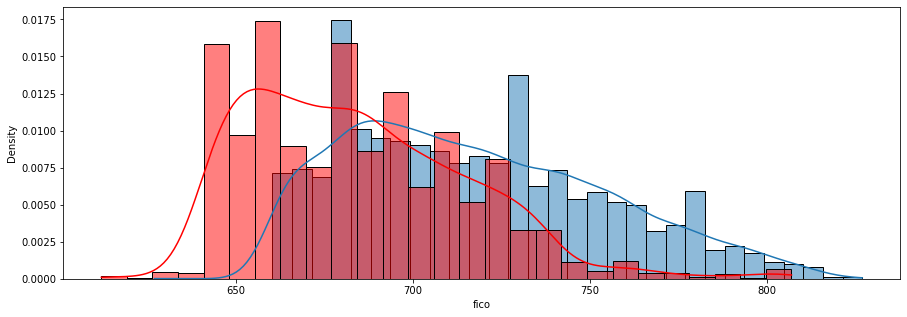

In [38]:

dfD = df[df["credit.policy"]>=1]
dfN = df[df["credit.policy"]<1]
dPos = dfD.fico
dNeg = dfN.fico

sns.histplot(dPos, kde=True, stat="density")
sns.histplot(dNeg, kde=True, stat="density", color='red')

In [39]:
meanPos, stdPos, varPos, nPos = dPos.mean(), dPos.std(), dPos.var(), dPos.count()
print(meanPos, stdPos, varPos, nPos)
meanNeg, stdNeg, varNeg, nNeg = dNeg.mean(), dNeg.std(), dNeg.var(), dNeg.count()
print(meanNeg, stdNeg, varNeg, nNeg)

717.3560311284047 36.63069719486368 1341.8079769817937 7710
683.978051391863 30.950970264507802 957.9625603144463 1868


In [40]:
stat, pval = scipy.stats.ttest_ind(dPos, dNeg)
pval

2.6100416830751396e-271

In [41]:
#Check for signifigance
cutoff = .05
if pval < cutoff:
    print("Reject null hypothesis - Effect appears significant")
else:
    print("Accept null hypothesis - Effect may be due to random chance")

Reject null hypothesis - Effect appears significant


<AxesSubplot:xlabel='fico', ylabel='Density'>

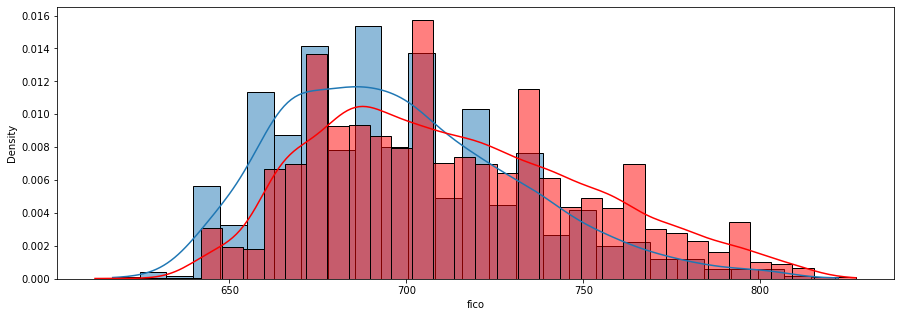

In [42]:
dfD = df[df["not.fully.paid"]==1]
dfN = df[df["not.fully.paid"]==0]
dPos = dfD.fico
dNeg = dfN.fico

sns.histplot(dPos, kde=True, stat="density")
sns.histplot(dNeg, kde=True, stat="density", color='red')

<AxesSubplot:xlabel='fico', ylabel='Density'>

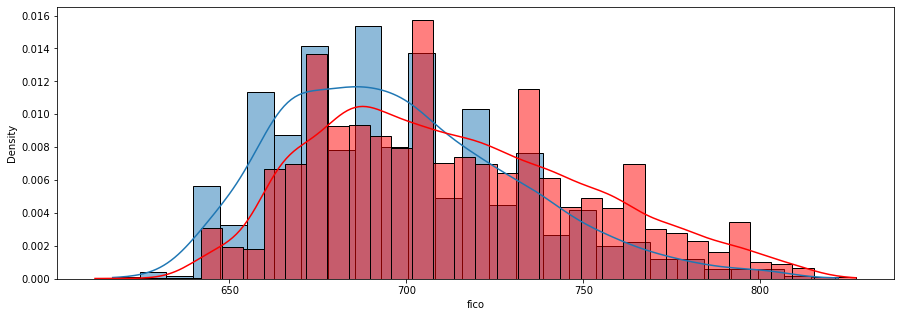

In [43]:
dfD = df[df["not.fully.paid"]==1]
dfN = df[df["not.fully.paid"]==0]
dPos = dfD.fico
dNeg = dfN.fico

sns.histplot(dPos, kde=True, stat="density")
sns.histplot(dNeg, kde=True, stat="density", color='red')

## Solutions